In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.special import softmax
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

raw_df = pd.read_csv('Potato-Prolific-Dataset-main/dataset/offensiveness/raw_data.csv')
raw_df = raw_df.dropna(subset=['text','offensiveness','race'])
raw_df['offensiveness'] = raw_df['offensiveness'].astype(int)
raw_df['labels'] = (raw_df['offensiveness'] > 1).astype(int)

_, test_df = train_test_split(
    raw_df, test_size=0.2, stratify=raw_df['labels'], random_state=42
)
test_texts = test_df['text'].tolist()
test_labels = test_df['labels'].values
test_races = test_df['race'].values



In [18]:
count_arab = test_df['race'].value_counts().get('Arab American', 0)
count_arab

7

C:\Users\34800\AppData\Local\Temp\ipykernel_20032\1450576667.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_df, y='race', order=test_df['race'].value_counts().index, palette='viridis')


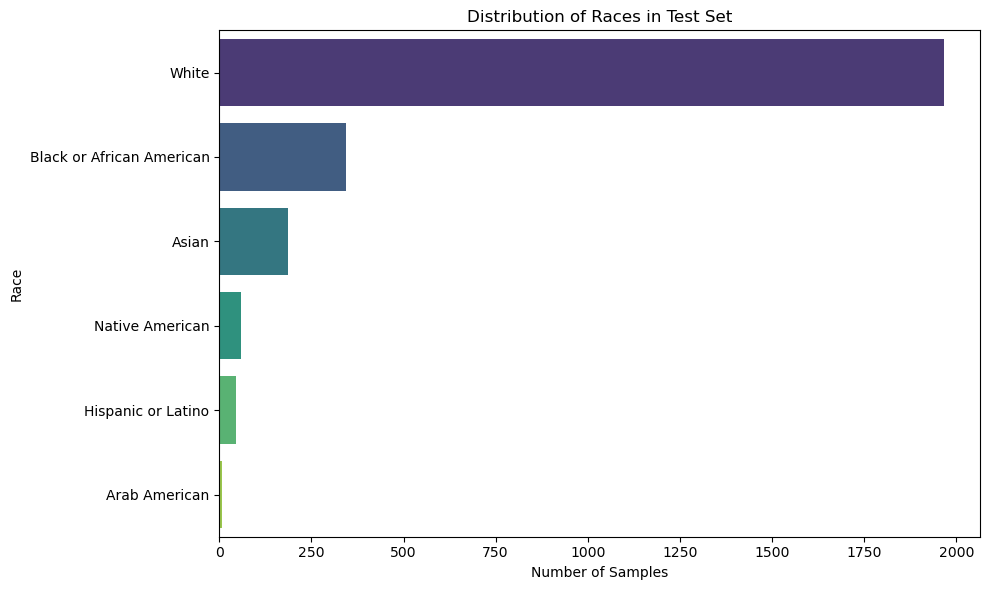

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=test_df, y='race', order=test_df['race'].value_counts().index, palette='viridis')
plt.title('Distribution of Races in Test Set')
plt.xlabel('Number of Samples')
plt.ylabel('Race')
plt.tight_layout() 
plt.show()

In [ ]:
ensemble_models = [
    # RoBERTa 5
    ('roberta1', 'roberta-base', 'models/roberta_binary_seed42.bin'),
    ('roberta2', 'roberta-base', 'models/roberta_binary_seed128.bin'),
    ('roberta3', 'roberta-base', 'models/roberta_binary_seed256.bin'),
    ('roberta4', 'roberta-base', 'models/roberta_binary_seed512.bin'),
    ('roberta5', 'roberta-base', 'models/roberta_binary_seed2025.bin'),
    # BERT 5
    ('bert1', 'bert-base-uncased', 'models/bert_seed42.bin'),
    ('bert2', 'bert-base-uncased', 'models/bert_seed128.bin'),
    ('bert3', 'bert-base-uncased', 'models/bert_seed256.bin'),
    ('bert4', 'bert-base-uncased', 'models/bert_seed1024.bin'),
    ('bert5', 'bert-base-uncased', 'models/bert_seed2025.bin'),
]
NUM_LABELS = 2
MAX_LENGTH = 128
BATCH_SIZE = 16


In [ ]:
all_logits = []  
model_names = []  

for (model_id, pretrained, ckpt) in ensemble_models:
    print(f"Predicting with {model_id} ({pretrained}) ...")
    tokenizer = AutoTokenizer.from_pretrained(pretrained)
    model = AutoModelForSequenceClassification.from_pretrained(pretrained, num_labels=NUM_LABELS)
    checkpoint = torch.load(ckpt, map_location=device)
    if "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    model.eval()
    model.to(device)

    logits_list = []
    with torch.no_grad():
        for i in tqdm(range(0, len(test_texts), BATCH_SIZE)):
            batch_text = test_texts[i:i+BATCH_SIZE]
            encoded = tokenizer(
                batch_text,
                padding='max_length',
                truncation=True,
                max_length=MAX_LENGTH,
                return_tensors='pt'
            )
            for k in encoded:
                encoded[k] = encoded[k].to(device)
            with torch.cuda.amp.autocast(enabled=False):
                out = model(**encoded)
                batch_logits = out.logits.cpu().numpy()
            logits_list.append(batch_logits)
    model_preds = np.concatenate(logits_list, axis=0)
    all_logits.append(model_preds)
    model_names.append(model_id)
    del model; torch.cuda.empty_cache()
print("All models predicted.")


Predicting with roberta1 (roberta-base) ...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\34800\AppData\Local\Temp\ipykernel_20032\3784427017.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode un

Predicting with roberta2 (roberta-base) ...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 163/163 [00:33<00:00,  4.94it/s]


Predicting with roberta3 (roberta-base) ...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 163/163 [00:22<00:00,  7.39it/s]


Predicting with roberta4 (roberta-base) ...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 163/163 [00:22<00:00,  7.16it/s]


Predicting with roberta5 (roberta-base) ...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 163/163 [00:23<00:00,  6.91it/s]


Predicting with bert1 (bert-base-uncased) ...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 163/163 [00:26<00:00,  6.27it/s]


Predicting with bert2 (bert-base-uncased) ...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 163/163 [00:27<00:00,  5.96it/s]


Predicting with bert3 (bert-base-uncased) ...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 163/163 [00:27<00:00,  5.92it/s]


Predicting with bert4 (bert-base-uncased) ...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 163/163 [00:27<00:00,  5.84it/s]


Predicting with bert5 (bert-base-uncased) ...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 163/163 [00:28<00:00,  5.63it/s]

All models predicted.


In [ ]:
for i, name in enumerate(model_names):
    pred = all_logits[i].argmax(axis=1)
    print(f"\n=== Single Model {name} ===\n")
    print(classification_report(test_labels, pred, digits=4))

# RoBERTa
roberta_idx = [i for i,name in enumerate(model_names) if name.startswith('roberta')]
if roberta_idx:
    probs_roberta = [softmax(all_logits[i], axis=1) for i in roberta_idx]
    roberta_avgp = np.mean(probs_roberta,axis=0)
    r_pred = np.argmax(roberta_avgp, axis=1)
    print("\n=== All RoBERTa (soft vote ensemble) ===\n")
    print(classification_report(test_labels, r_pred, digits=4))

# BERT
bert_idx = [i for i,name in enumerate(model_names) if name.startswith('bert')]
if bert_idx:
    probs_bert = [softmax(all_logits[i], axis=1) for i in bert_idx]
    bert_avgp = np.mean(probs_bert,axis=0)
    b_pred = np.argmax(bert_avgp, axis=1)
    print("\n=== All BERT (soft vote ensemble) ===\n")
    print(classification_report(test_labels, b_pred, digits=4))

# all model soft vote
probs_list = [softmax(x, axis=1) for x in all_logits]
avg_probs = np.mean(probs_list, axis=0)
soft_preds = np.argmax(avg_probs, axis=1)
print("\n=== ALL models Soft Voting ===\n")
print(classification_report(test_labels, soft_preds, digits=4))

# all model hard vote
hard_preds_list = [np.argmax(x, axis=1) for x in all_logits]
hard_mat = np.stack(hard_preds_list, axis=0)
hard_preds = mode(hard_mat, axis=0).mode.squeeze()
print("\n=== ALL models Hard Voting ===\n")
print(classification_report(test_labels, hard_preds, digits=4))


C:\Users\34800\AppData\Local\Temp\ipykernel_20032\1033153860.py:35: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  hard_preds = mode(hard_mat, axis=0).mode.squeeze()



=== Single Model roberta1 ===

              precision    recall  f1-score   support

           0     0.7849    0.6727    0.7245      1503
           1     0.6270    0.7491    0.6826      1104

    accuracy                         0.7050      2607
   macro avg     0.7060    0.7109    0.7035      2607
weighted avg     0.7181    0.7050    0.7068      2607


=== Single Model roberta2 ===

              precision    recall  f1-score   support

           0     0.7720    0.7345    0.7528      1503
           1     0.6610    0.7047    0.6822      1104

    accuracy                         0.7219      2607
   macro avg     0.7165    0.7196    0.7175      2607
weighted avg     0.7250    0.7219    0.7229      2607


=== Single Model roberta3 ===

              precision    recall  f1-score   support

           0     0.7707    0.7112    0.7398      1503
           1     0.6443    0.7120    0.6764      1104

    accuracy                         0.7115      2607
   macro avg     0.7075    0.711

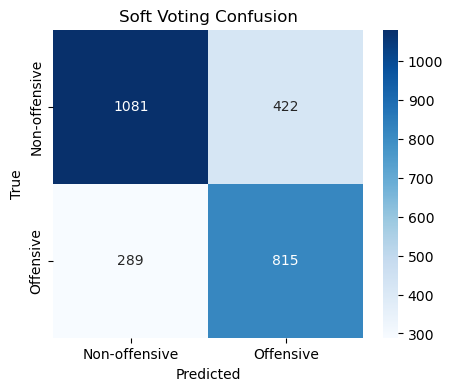

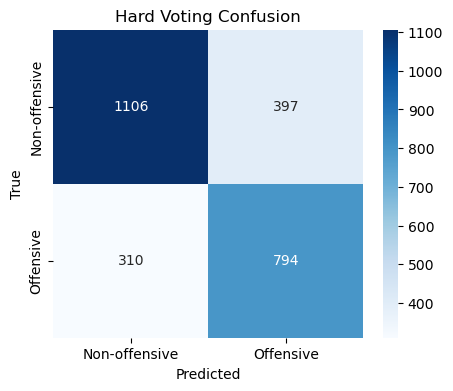

In [5]:
def plot_conf_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_conf_matrix(test_labels, soft_preds, class_names=["Non-offensive", "Offensive"], title="Soft Voting Confusion")
plot_conf_matrix(test_labels, hard_preds, class_names=["Non-offensive", "Offensive"], title="Hard Voting Confusion")


In [ ]:
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score, recall_score, precision_score

mf = MetricFrame(
    metrics={'accuracy': accuracy_score, 'recall': recall_score, 'selection_rate': selection_rate},
    y_true=test_labels,
    y_pred=soft_preds,     
    sensitive_features=test_races
)
print(mf.overall)
print(mf.by_group)


accuracy          0.727273
recall            0.738225
selection_rate    0.474492
dtype: float64
                           accuracy    recall  selection_rate
sensitive_feature_0                                          
Arab American              0.571429  0.000000        0.428571
Asian                      0.779570  0.777778        0.489247
Black or African American  0.686047  0.675159        0.473837
Hispanic or Latino         0.688889  0.750000        0.444444
Native American            0.610169  0.714286        0.491525
White                      0.734486  0.746089        0.473550


d:\anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| Race                         | accuracy | recall   | selection_rate |
|------------------------------|----------|----------|---------------|
| Arab American                | 0.571    | 0.000    | 0.429         |
| Asian                        | 0.780    | 0.778    | 0.489         |
| Black or African American    | 0.686    | 0.675    | 0.474         |
| Hispanic or Latino           | 0.689    | 0.750    | 0.444         |
| Native American              | 0.610    | 0.714    | 0.492         |
| White                        | 0.734    | 0.746    | 0.474         |

<Figure size 1000x500 with 0 Axes>

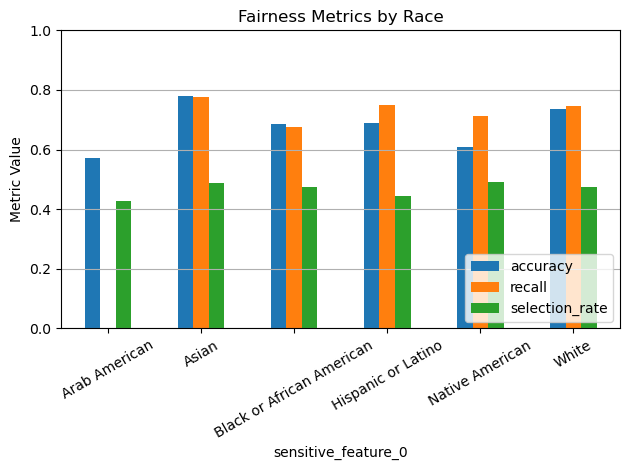

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
mf.by_group.plot(kind='bar')
plt.title(f'Fairness Metrics by Race')
plt.ylabel('Metric Value')
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()


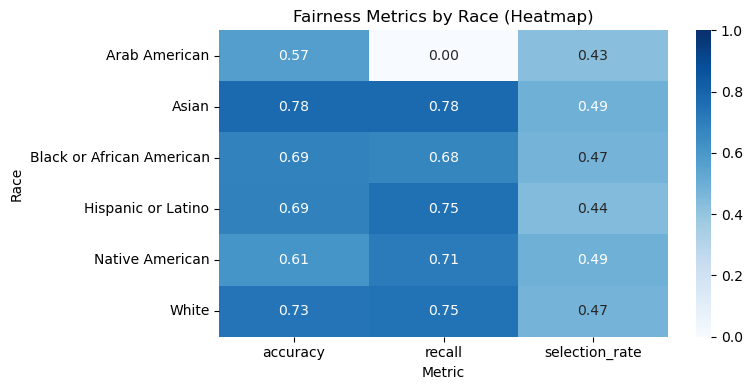

In [8]:
import numpy as np

plt.figure(figsize=(8,4))
sns.heatmap(mf.by_group, annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)
plt.title('Fairness Metrics by Race (Heatmap)')
plt.ylabel('Race')
plt.xlabel('Metric')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


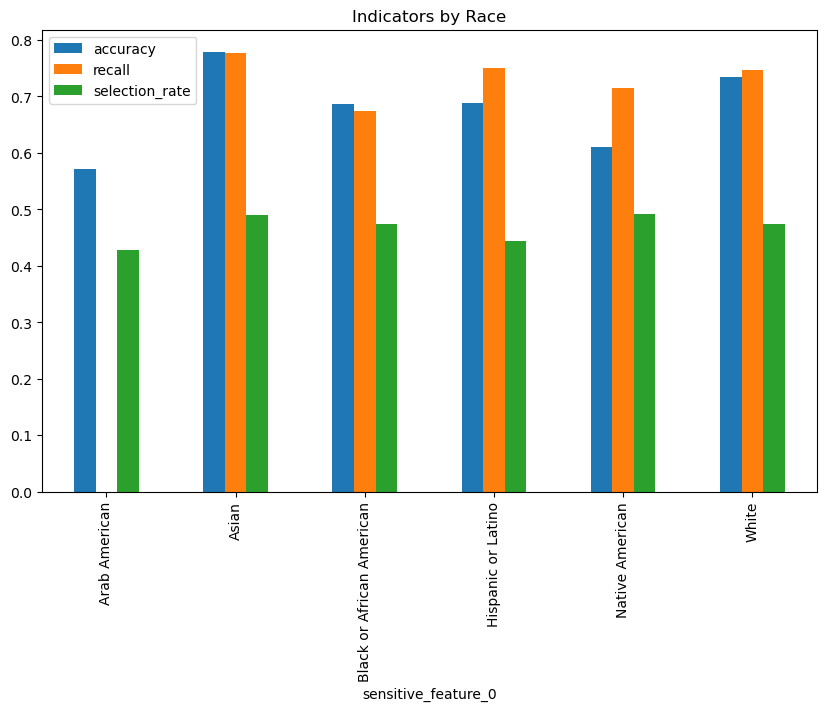

In [9]:
import matplotlib.pyplot as plt
mf.by_group.plot(kind='bar', figsize=(10,6))
plt.title("Indicators by Race")
plt.show()
